In [1]:
import m
import matplotlib.pyplot as plt
import datetime
import pandas as pd

# 00. table 기본 탐색

In [2]:
for table_ in ['products_info','train_x_past','train_x_current','train_y','test_x_past','test_x_current'] :
    m.table기본(table_)


 ***products_info*** 

- shape  :  (100, 6)
- colume :  ['product_id', 'name', 'category_id', 'division_id', 'category_name', 'division_name']
- colume_type 
 product_id       object
name             object
category_id      object
division_id      object
category_name    object
division_name    object
dtype: object
- unique
product_id  :  100
name  :  100
category_id  :  21
division_id  :  9
category_name  :  21
division_name  :  9
----------------------------------------------

 ***train_x_past*** 

- shape  :  (1253972, 9)
- colume :  ['order_id', 'cstno', 'order_number', 'week_day', 'order_hour', 'order_interval', 'add_order', 'is_reordered', 'product_id']
- colume_type 
 order_id          object
cstno             object
order_number      object
week_day          object
order_hour        object
order_interval    object
add_order         object
is_reordered      object
product_id        object
dtype: object
- unique
order_id  :  341678
cstno  :  5859
order_number  :  99
week_day  : 

# 01. EDA(train past, train current, test past merge)

In [3]:
products_info = m._read_table('products_info')

In [4]:
train_past = m._read_table('train_x_past')

In [5]:
train_y_current = m._read_table('train_y')

In [6]:
train_x_current = m._read_table('train_x_current')

In [7]:
train_current = m.pd.concat([train_x_current,train_y_current],axis=1)

In [8]:
test_past = m._read_table('test_x_past')

In [9]:
EDA_data = m.pd.concat([train_past,train_current,test_past],axis=0).reset_index(drop=True)

- EDA용으로 train past data에 product정보 붙이기

In [10]:
EDA_data = EDA_data.merge(products_info,on='product_id',how='left')
EDA_data.head(5)

,order_id,cstno,order_number,week_day,order_hour,order_interval,add_order,is_reordered,product_id,name,category_id,division_id,category_name,division_name
0,717029,196613,15,1,9,3.0,5,0,41220,Organic Romaine Lettuce,83,4,fresh vegetables,produce
1,2325772,196613,35,6,11,2.0,7,1,41220,Organic Romaine Lettuce,83,4,fresh vegetables,produce
2,642668,196613,69,2,16,2.0,11,1,4210,Whole Milk,84,16,milk,dairy eggs
3,1326515,196613,61,3,19,3.0,3,1,4210,Whole Milk,84,16,milk,dairy eggs
4,1437845,196613,36,3,15,4.0,16,0,4210,Whole Milk,84,16,milk,dairy eggs


#### 상품별 구매 분포
- banana, Bag of Organic Bananas, Organic Strawberries 순으로 가장 많이 주문함.

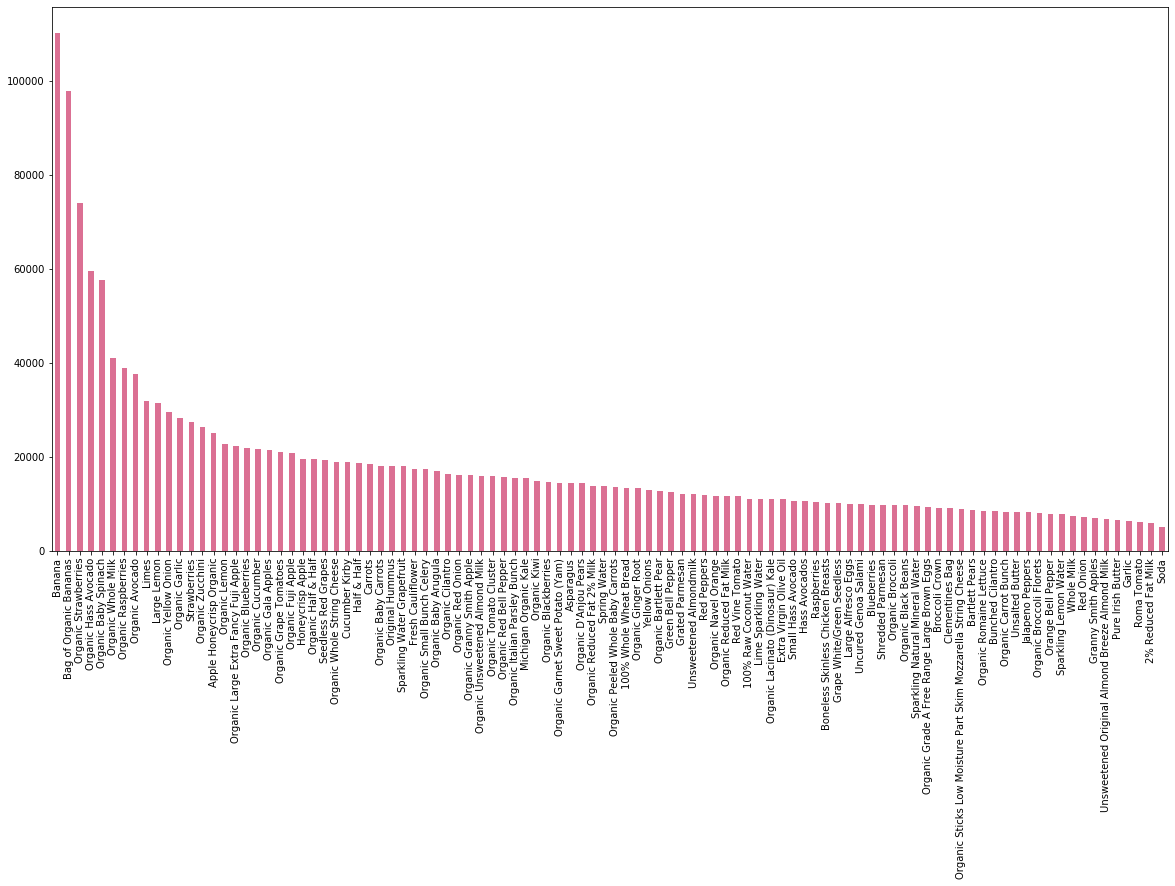

In [11]:
plt.figure(figsize=(20,10))
EDA_data['name'].value_counts().plot(kind='bar',color='palevioletred')
plt.show()

#### 상품 카테고리별 구매 수 분포
- fresh fruits, fresh vegetables, packeged vegetables fruits순으로 구매가 많음.

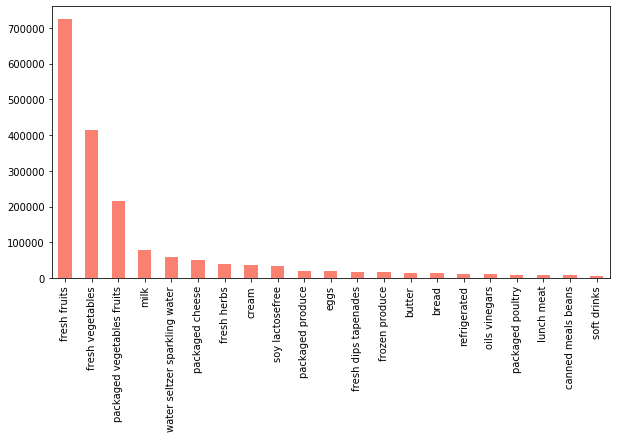

In [12]:
plt.figure(figsize=(10,5))
EDA_data['category_name'].value_counts().plot(kind='bar',color='salmon')
plt.show()

#### 요일별 주문 건 수 분포
- 일요일, 월요일이 구매가 많음.

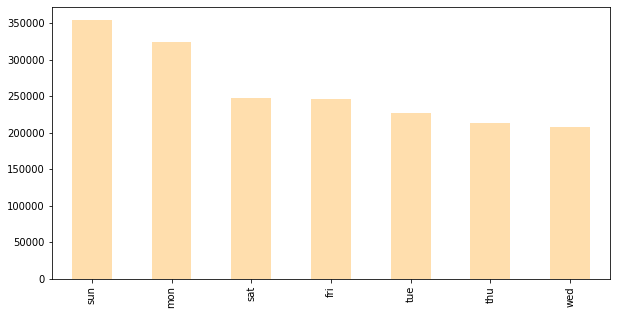

In [13]:
EDA_data.loc[EDA_data.week_day=='0','week_day_cha'] = 'sun'
EDA_data.loc[EDA_data.week_day=='1','week_day_cha'] = 'mon'
EDA_data.loc[EDA_data.week_day=='2','week_day_cha'] = 'tue'
EDA_data.loc[EDA_data.week_day=='3','week_day_cha'] = 'wed'
EDA_data.loc[EDA_data.week_day=='4','week_day_cha'] = 'thu'
EDA_data.loc[EDA_data.week_day=='5','week_day_cha'] = 'fri'
EDA_data.loc[EDA_data.week_day=='6','week_day_cha'] = 'sat'

plt.figure(figsize=(10,5))
EDA_data['week_day_cha'].value_counts().plot(kind='bar',color='navajowhite')
plt.show()

#### 시간대별 주문 건 수 분포
- 10시, 9시, 11시 순, 8~16시로 몰려있음.

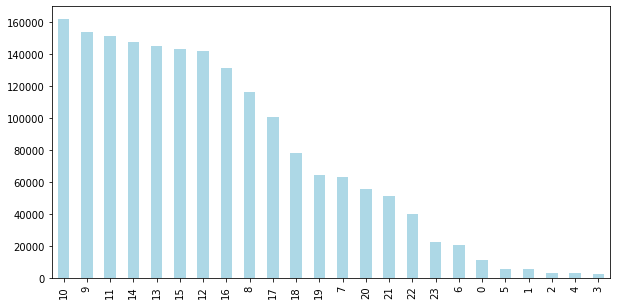

In [14]:
plt.figure(figsize=(10,5))
EDA_data['order_hour'].value_counts().plot(kind='bar',color='lightblue')
plt.show()

#### 유기농 구분
- 유기농 주문 수가 더 많음.

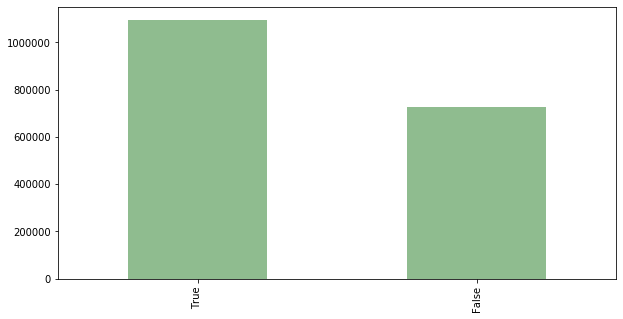

In [15]:
EDA_data['is_organic'] = EDA_data['name'].str.contains('Organic')

plt.figure(figsize=(10,5))
EDA_data['is_organic'].value_counts().plot(kind='bar',color='darkseagreen')
plt.show()

#### 전체 재구매 비율 확인
- 재구매가 1,550,480건으로, 전체 구매 중 85%를 차지

In [16]:
EDA_data.is_reordered.value_counts()

1    1550480
0     269838
Name: is_reordered, dtype: int64

#### 10번 이상 주문한 고객 수 : 10,00명

In [17]:
a = EDA_data.groupby(['cstno'])['order_id'].count().reset_index()
len(a.loc[a.order_id >= 10])

10000

#### 통계학적 특성 산출을 위해 컬럼을 int로 형전환
- order_interval int로 바꾸기위한 전처리
- 고객의 첫 구매시 order_interval   ''로 들어가 있음. (0으로 전환)

In [18]:
EDA_data.loc[EDA_data.cstno == '196613'].sort_values(['order_number','add_order'],ascending=[True,True]).head(5)

,order_id,cstno,order_number,week_day,order_hour,order_interval,add_order,is_reordered,product_id,name,category_id,division_id,category_name,division_name,week_day_cha,is_organic
57,1175721,196613,1,6,13,,10,0,24184,Red Peppers,83,4,fresh vegetables,produce,sat,False
112,1175721,196613,1,6,13,,5,0,17794,Carrots,83,4,fresh vegetables,produce,sat,False
185,1175721,196613,1,6,13,,8,0,24852,Banana,24,4,fresh fruits,produce,sat,False
1278142,2414402,196613,100,6,13,5.0,1,1,24852,Banana,24,4,fresh fruits,produce,sat,False
1255604,2414402,196613,100,6,13,5.0,4,1,43122,Organic Bartlett Pear,24,4,fresh fruits,produce,sat,True


In [19]:
EDA_data.order_interval = EDA_data.order_interval.apply(lambda x : x[:-2])
EDA_data.order_interval.replace('','0',inplace=True)

In [20]:
EDA_data.loc[EDA_data.cstno == '196613'].sort_values(['order_number','add_order'],ascending=[True,True]).head(5)

,order_id,cstno,order_number,week_day,order_hour,order_interval,add_order,is_reordered,product_id,name,category_id,division_id,category_name,division_name,week_day_cha,is_organic
57,1175721,196613,1,6,13,0,10,0,24184,Red Peppers,83,4,fresh vegetables,produce,sat,False
112,1175721,196613,1,6,13,0,5,0,17794,Carrots,83,4,fresh vegetables,produce,sat,False
185,1175721,196613,1,6,13,0,8,0,24852,Banana,24,4,fresh fruits,produce,sat,False
1278142,2414402,196613,100,6,13,5,1,1,24852,Banana,24,4,fresh fruits,produce,sat,False
1255604,2414402,196613,100,6,13,5,4,1,43122,Organic Bartlett Pear,24,4,fresh fruits,produce,sat,True


In [21]:
for column in ['order_number','week_day','order_hour','order_interval','add_order','is_reordered'] :
    EDA_data[f'{column}'] = EDA_data[f'{column}'].astype('int')

# 02. 유의미한 파생 변수 생성

## 1. TRAIN

In [22]:
train_past = m._read_table('train_x_past')

In [23]:
train_y_current = m._read_table('train_y')

In [24]:
train_x_current = m._read_table('train_x_current')

In [25]:
train_current = m.pd.concat([train_x_current,train_y_current],axis=1)

In [26]:
train = m.pd.concat([train_past,train_current],axis=0)

In [27]:
test = m._read_table('test_x_past')

In [28]:
train.order_interval = train.order_interval.apply(lambda x : x[:-2])
train.order_interval.replace('','0',inplace=True)

In [29]:
for column in ['order_number','week_day','order_hour','order_interval','add_order','is_reordered'] :
    train[f'{column}'] = train[f'{column}'].astype('int')

In [30]:
test.order_interval = test.order_interval.apply(lambda x : x[:-2])
test.order_interval.replace('','0',inplace=True)

In [31]:
for column in ['order_number','week_day','order_hour','order_interval','add_order','is_reordered'] :
    test[f'{column}'] = test[f'{column}'].astype('int')

### ⅰ.상품별 통계학적 특성 (products_stat)

- 고객/상품별로 구매횟수 컬럼 생성 (product_time)

In [32]:
train['product_time'] = train.groupby(['cstno','product_id'])['order_number'].rank(method='min',ascending=False)

In [33]:
train.sort_values(['cstno','product_id','product_time'],ascending=True).head(5)

,order_id,cstno,order_number,week_day,order_hour,order_interval,add_order,is_reordered,product_id,product_time
423346,1990815,10000,71,1,13,2,8,1,10749,1.0
423340,343340,10000,67,0,12,8,4,1,10749,2.0
423348,2477429,10000,61,2,8,6,3,1,10749,3.0
423338,193643,10000,56,0,7,10,6,1,10749,4.0
423342,664258,10000,49,0,11,7,6,1,10749,5.0


#### 상품별 재구매비율 계산
- Banana, Organic Reduced Fat Milk, Bag of Organic Bananas, Soda 순으로 높음.

In [34]:
# 해당 상품의 구매빈도 (prod_N)
products_stat_train = train.product_id.value_counts().reset_index().rename(columns={'index':'product_id','product_id':'prod_N'})

In [35]:
products_stat_train = products_stat_train.merge(products_info[['product_id','name']],on='product_id',how='left')

In [36]:
b = train.groupby(['product_id'])['is_reordered'].sum().reset_index().rename(columns={'index':'product_id','is_reordered':'a'})

In [37]:
products_stat_train = products_stat_train.merge(b,on='product_id',how='left')

In [38]:
# 해당상품의 전체 판매 중 재구매에 의한 판매 비율 (prod_ReorderedRatio)
products_stat_train['prod_ReorderedRatio'] = products_stat_train.a/products_stat_train.prod_N

In [39]:
products_stat_train.drop(columns='a',inplace=True)

In [40]:
products_stat_train.sort_values(['prod_ReorderedRatio'],ascending=False).head(5)

,product_id,prod_N,name,prod_ReorderedRatio
0,24852,76026,Banana,0.952582
1,13176,68949,Bag of Organic Bananas,0.942987
54,38689,8988,Organic Reduced Fat Milk,0.942813
99,196,2754,Soda,0.936819
5,27845,30274,Organic Whole Milk,0.933474


#### 상품별 재구매확률 계산
 - Organic Strawberries, Bag of Organic Bananas, Banana 순으로 높음

In [41]:
b=train.groupby(['product_id','product_time'],as_index=False)['order_id'].count()

In [42]:
# 해당 상품을 처음 구매한 고객 수(prod_FirstOrders)
b_1 = b.loc[b.product_time == 1].rename(columns={'order_id':'prod_FirstOrders'})

In [43]:
b_2 = b.loc[b.product_time == 2]

In [44]:
b = b_1.merge(b_2,on='product_id',how='left')

In [45]:
# 해당 상품을 재구매할 확률(prod_ReorderedProb)
b['prod_ReorderedProb'] = b.order_id/b.prod_FirstOrders

In [46]:
products_stat_train = products_stat_train.merge(b[['product_id','prod_FirstOrders','prod_ReorderedProb']],on='product_id',how='left')

In [47]:
products_stat_train.sort_values(['prod_ReorderedProb'],ascending=False).head(5)

,product_id,prod_N,name,prod_ReorderedRatio,prod_FirstOrders,prod_ReorderedProb
2,21137,54032,Organic Strawberries,0.918215,4419,0.894773
1,13176,68949,Bag of Organic Bananas,0.942987,3931,0.885271
0,24852,76026,Banana,0.952582,3605,0.878225
4,21903,40795,Organic Baby Spinach,0.909621,3687,0.868999
3,47209,43298,Organic Hass Avocado,0.919511,3485,0.867145


#### 중위수 이용
- 해당상품이 주로 주문되는 시간(prod_OrderedTime)
- 해당상품의 재주문 기간(prod_ReorderedPeriod)
- 해당 상품이 주로 장바구니에 담기는 순서(prod_CartOrder)

In [48]:
b = train.groupby(['product_id'],as_index=False)['order_hour','order_interval','add_order'].median().rename(columns={'order_hour':'prod_OrderedTime','order_interval':'prod_ReorderedPeriod','add_order':'prod_CartOrder'})

/opt/conda/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


In [49]:
products_stat_train= products_stat_train.merge(b[['product_id','prod_OrderedTime','prod_ReorderedPeriod','prod_CartOrder']],on='product_id',how='left').reset_index(drop=True)

In [50]:
products_stat_train.drop(columns='name',inplace=True)

### ⅱ. 고객의 통계 정보 및 주문 정보 (users_stat)

In [51]:
# 고객별 총 주문 횟수 & 평균 주문간격 & 상품의 개수
users_stat_train = train.groupby('cstno',as_index=False).agg({'order_id':'count', 'order_interval':'mean'})

In [52]:
# 고객별 주문한 상품의 개수
a = train.groupby(['cstno'],as_index=False)['product_id'].nunique().rename(columns={'product_id':'pl_N'})

In [53]:
users_stat_train = users_stat_train.merge(a,on='cstno',how='left')

In [54]:
users_stat_train

,cstno,order_id,order_interval,pl_N
0,10000,345,5.139130,44
1,100001,353,6.192635,40
2,100046,235,5.357447,33
3,100071,227,5.991189,27
4,100108,176,5.238636,22
...,...,...,...,...
5854,9981,100,7.260000,9
5855,99829,244,7.995902,43
5856,99887,370,4.275676,23
5857,99894,176,5.909091,28


In [55]:
b=train.groupby(['cstno','product_time'],as_index=False)['order_id'].count()

In [56]:
b_1 = b.loc[b.product_time == 1].rename(columns={'order_id':'a'})

In [57]:
b_2 = b.loc[b.product_time == 2].rename(columns={'order_id':'c'})

In [58]:
b = b_1.merge(b_2,on='cstno',how='left')

In [59]:
#재구매비율
b['user_ReorderedRatio'] = b.a/b.c

In [60]:
users_stat_train = users_stat_train.merge(b[['cstno','user_ReorderedRatio']],on='cstno',how='left')

In [61]:
users_stat_train.head(5)

,cstno,order_id,order_interval,pl_N,user_ReorderedRatio
0,10000,345,5.139130,44,1.517241
1,100001,353,6.192635,40,1.290323
2,100046,235,5.357447,33,1.375000
3,100071,227,5.991189,27,1.125000
4,100108,176,5.238636,22,1.294118


### ⅲ. 고객별 구매 상품 리스트 (purchase_list)

In [62]:
purchase_list_train = train.groupby(['cstno','product_id'],as_index=False)['order_number'].count().rename(columns={'order_number':'pl_N'})

In [63]:
a = train.groupby(['cstno','product_id'],as_index=False)['order_number'].min().rename(columns={'order_number':'pl_FirstPurchase'})

In [64]:
purchase_list_train = purchase_list_train.merge(a,on=['cstno','product_id'],how='left')

In [65]:
b = train.groupby(['cstno','product_id'],as_index=False)['order_number'].max().rename(columns={'order_number':'pl_LastPurchase'})

In [66]:
purchase_list_train = purchase_list_train.merge(b,on=['cstno','product_id'],how='left')

In [67]:
c = train.groupby(['cstno','product_id'],as_index=False)['add_order'].median().rename(columns={'add_order':'pl_CartOrder'})

In [68]:
purchase_list_train = purchase_list_train.merge(c,on=['cstno','product_id'],how='left')

In [69]:
purchase_list_train.head(5)

,cstno,product_id,pl_N,pl_FirstPurchase,pl_LastPurchase,pl_CartOrder
0,10000,10749,15,10,71,6.0
1,10000,11520,15,40,72,6.0
2,10000,13176,6,10,57,11.0
3,10000,15290,5,1,59,10.0
4,10000,16759,1,40,40,17.0


In [70]:
purchase_list_train = purchase_list_train.merge(products_stat_train,on='product_id',how='inner')

In [71]:
purchase_list_train = purchase_list_train.merge(users_stat_train,on='cstno',how='inner')

In [72]:
train_X = purchase_list_train.drop(columns='product_id')

In [73]:
train_y = purchase_list_train['product_id']

## 2. TEST

### ⅰ.상품별 통계학적 특성 (products_stat)

- 고객/상품별로 구매횟수 컬럼 생성 (product_time)

In [74]:
test['product_time'] = test.groupby(['cstno','product_id'])['order_number'].rank(method='min',ascending=False)

In [75]:
test.sort_values(['cstno','product_id','product_time'],ascending=True).head(5)

,order_id,cstno,order_number,week_day,order_hour,order_interval,add_order,is_reordered,product_id,product_time
500569,886128,100041,39,6,11,11,4,1,13176,1.0
500580,2483732,100041,33,3,14,3,1,1,13176,2.0
500576,1881946,100041,31,4,7,4,4,1,13176,3.0
500583,2893588,100041,30,0,11,8,9,1,13176,4.0
500567,774277,100041,29,6,15,19,4,1,13176,5.0


#### 상품별 재구매비율 계산
- Banana, Organic Reduced Fat Milk, Bag of Organic Bananas, Soda 순으로 높음.

In [76]:
# 해당 상품의 구매빈도 (prod_N)
products_stat_test = test.product_id.value_counts().reset_index().rename(columns={'index':'product_id','product_id':'prod_N'})

In [77]:
products_stat_test = products_stat_test.merge(products_info[['product_id','name']],on='product_id',how='left')

In [78]:
b = test.groupby(['product_id'])['is_reordered'].sum().reset_index().rename(columns={'index':'product_id','is_reordered':'a'})

In [79]:
products_stat_test = products_stat_test.merge(b,on='product_id',how='left')

In [80]:
# 해당상품의 전체 판매 중 재구매에 의한 판매 비율 (prod_ReorderedRatio)
products_stat_test['prod_ReorderedRatio'] = products_stat_test.a/products_stat_test.prod_N

In [81]:
products_stat_test.drop(columns='a',inplace=True)

In [82]:
products_stat_test.sort_values(['prod_ReorderedRatio'],ascending=False).head(5)

,product_id,prod_N,name,prod_ReorderedRatio
0,24852,34287,Banana,0.930119
96,196,2241,Soda,0.922802
1,13176,29086,Bag of Organic Bananas,0.915526
85,38689,2644,Organic Reduced Fat Milk,0.905068
91,23909,2335,2% Reduced Fat Milk,0.902784


#### 상품별 재구매확률 계산
 - Organic Strawberries, Bag of Organic Bananas, Banana 순으로 높음

In [83]:
b=test.groupby(['product_id','product_time'],as_index=False)['order_id'].count()

In [84]:
# 해당 상품을 처음 구매한 고객 수(prod_FirstOrders)
b_1 = b.loc[b.product_time == 1].rename(columns={'order_id':'prod_FirstOrders'})

In [85]:
b_2 = b.loc[b.product_time == 2]

In [86]:
b = b_1.merge(b_2,on='product_id',how='left')

In [87]:
# 해당 상품을 재구매할 확률(prod_ReorderedProb)
b['prod_ReorderedProb'] = b.order_id/b.prod_FirstOrders

In [88]:
products_stat_test = products_stat_test.merge(b[['product_id','prod_FirstOrders','prod_ReorderedProb']],on='product_id',how='left')

In [89]:
products_stat_test.sort_values(['prod_ReorderedProb'],ascending=False).head(5)

,product_id,prod_N,name,prod_ReorderedRatio,prod_FirstOrders,prod_ReorderedProb
0,24852,34287,Banana,0.930119,2396,0.879382
1,13176,29086,Bag of Organic Bananas,0.915526,2457,0.868539
2,21137,20064,Organic Strawberries,0.868820,2632,0.832447
4,47209,16237,Organic Hass Avocado,0.877872,1983,0.830560
3,21903,16974,Organic Baby Spinach,0.869860,2209,0.822997


#### 중위수 이용
- 해당상품이 주로 주문되는 시간(prod_OrderedTime)
- 해당상품의 재주문 기간(prod_ReorderedPeriod)
- 해당 상품이 주로 장바구니에 담기는 순서(prod_CartOrder)

In [90]:
b = test.groupby(['product_id'],as_index=False)['order_hour','order_interval','add_order'].median().rename(columns={'order_hour':'prod_OrderedTime','order_interval':'prod_ReorderedPeriod','add_order':'prod_CartOrder'})

/opt/conda/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


In [91]:
products_stat_test= products_stat_test.merge(b[['product_id','prod_OrderedTime','prod_ReorderedPeriod','prod_CartOrder']],on='product_id',how='left').reset_index(drop=True)

In [92]:
products_stat_test.drop(columns='name',inplace=True)

### ⅱ. 고객의 통계 정보 및 주문 정보 (users_stat)

In [93]:
# 고객별 총 주문 횟수 & 평균 주문간격 & 상품의 개수
users_stat_test = test.groupby('cstno',as_index=False).agg({'order_id':'count', 'order_interval':'mean'})

In [94]:
# 고객별 주문한 상품의 개수
a = test.groupby(['cstno'],as_index=False)['product_id'].nunique().rename(columns={'product_id':'pl_N'})

In [95]:
users_stat_test = users_stat_test.merge(a,on='cstno',how='left')

In [96]:
users_stat_test

,cstno,order_id,order_interval,pl_N
0,100041,163,8.319018,29
1,100103,137,6.883212,16
2,100165,127,9.527559,25
3,100270,46,7.217391,5
4,100359,171,10.280702,32
...,...,...,...,...
4136,99897,177,8.333333,29
4137,999,284,9.116197,39
4138,99915,206,9.466019,35
4139,99963,85,3.647059,22


In [97]:
b=test.groupby(['cstno','product_time'],as_index=False)['order_id'].count()

In [98]:
b_1 = b.loc[b.product_time == 1].rename(columns={'order_id':'a'})

In [99]:
b_2 = b.loc[b.product_time == 2].rename(columns={'order_id':'c'})

In [100]:
b = b_1.merge(b_2,on='cstno',how='left')

In [101]:
#재구매비율
b['user_ReorderedRatio'] = b.a/b.c

In [102]:
users_stat_test = users_stat_test.merge(b[['cstno','user_ReorderedRatio']],on='cstno',how='left')

In [103]:
users_stat_test.head(5)

,cstno,order_id,order_interval,pl_N,user_ReorderedRatio
0,100041,163,8.319018,29,1.260870
1,100103,137,6.883212,16,1.333333
2,100165,127,9.527559,25,1.470588
3,100270,46,7.217391,5,1.666667
4,100359,171,10.280702,32,1.333333


### ⅲ. 고객별 구매 상품 리스트 (purchase_list)

In [104]:
purchase_list_test = test.groupby(['cstno','product_id'],as_index=False)['order_number'].count().rename(columns={'order_number':'pl_N'})

In [105]:
a = test.groupby(['cstno','product_id'],as_index=False)['order_number'].min().rename(columns={'order_number':'pl_FirstPurchase'})

In [106]:
purchase_list_test = purchase_list_test.merge(a,on=['cstno','product_id'],how='left')

In [107]:
b = test.groupby(['cstno','product_id'],as_index=False)['order_number'].max().rename(columns={'order_number':'pl_LastPurchase'})

In [108]:
purchase_list_test = purchase_list_test.merge(b,on=['cstno','product_id'],how='left')

In [109]:
c = test.groupby(['cstno','product_id'],as_index=False)['add_order'].median().rename(columns={'add_order':'pl_CartOrder'})

In [110]:
purchase_list_test = purchase_list_test.merge(c,on=['cstno','product_id'],how='left')

In [111]:
purchase_list_test.head(5)

,cstno,product_id,pl_N,pl_FirstPurchase,pl_LastPurchase,pl_CartOrder
0,100041,13176,19,1,39,5.0
1,100041,17794,2,21,27,8.0
2,100041,21137,5,3,39,10.0
3,100041,21616,2,7,40,4.0
4,100041,21903,16,1,31,4.0


In [112]:
purchase_list_test = purchase_list_test.merge(products_stat_test,on='product_id',how='inner')

In [113]:
purchase_list_test = purchase_list_test.merge(users_stat_test,on='cstno',how='inner')

In [114]:
purchase_list_test.head(5)

,cstno,product_id,pl_N_x,pl_FirstPurchase,pl_LastPurchase,pl_CartOrder,prod_N,prod_ReorderedRatio,prod_FirstOrders,prod_ReorderedProb,prod_OrderedTime,prod_ReorderedPeriod,prod_CartOrder,order_id,order_interval,pl_N_y,user_ReorderedRatio
0,100041,13176,19,1,39,5.0,29086,0.915526,2457,0.868539,13,7,4,163,8.319018,29,1.26087
1,100041,17794,2,21,27,8.0,5295,0.747686,1336,0.667665,13,7,7,163,8.319018,29,1.26087
2,100041,21137,5,3,39,10.0,20064,0.868820,2632,0.832447,13,7,6,163,8.319018,29,1.26087
3,100041,21616,2,7,40,4.0,5389,0.790499,1129,0.683791,13,7,7,163,8.319018,29,1.26087
4,100041,21903,16,1,31,4.0,16974,0.869860,2209,0.822997,13,7,6,163,8.319018,29,1.26087


In [ ]:
test_X = purchase_list_test.drop(columns='product_id')

In [116]:
test_y = purchase_list_test['product_id']

In [117]:
len(train_X)

171635

# 03. modeling

In [118]:
train_X = train_X.drop(columns='cstno')

In [119]:
test_X = test_X.drop(columns='cstno')

In [120]:
from xgboost import XGBClassifier

In [121]:
model_XGB = XGBClassifier()

In [122]:
model_XGB.fit(train_X,train_y)

/opt/conda/envs/python3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:13:31] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=48,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [123]:
y_pred = model_XGB.predict(test_X)

In [128]:
from sklearn.metrics import accuracy_score

In [129]:
accuracy_score(y_pred,test_y)

0.01340081260246632

In [151]:
len(test_x_current)

16126

In [130]:
test_x_current = m._read_table('test_x_current')

In [134]:
test_X = purchase_list_test.drop(columns='product_id')

In [141]:
final_test = pd.merge(test_x_current[['cstno']],test_X,on='cstno',how='left')

In [142]:
final_test = final_test.drop(columns='cstno')

In [144]:
final = model_XGB.predict(final_test)

In [148]:
final_df = pd.DataFrame({'y':final})

In [149]:
final_df.to_csv('test_y.csv')